In [45]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras import layers
import keras_tuner

#LSTM batch normalization


In [46]:
df = pd.read_csv('Monte_Carlo_10000/training_data_bending.csv')

In [47]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = df[['max_force']].values

In [48]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [49]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    #model.add(layers.Dropout(rate=0.2))
    #activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    units = hp.Int('units', min_value=16, max_value=128, step=16)
    num_layers = hp.Int('num_layers', 1, 10)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    for i in range(num_layers):
        model.add(layers.Dense(
            units=units, 
            activation='relu',
            ))
        #model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(
        units=1, 
        activation='relu'))
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate),
        loss='mse',
        metrics=['mse'])
    return model

hp = keras_tuner.HyperParameters()
build_model(hp)

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='mse',
    max_trials=200,
    executions_per_trial=3,
    directory='keras_tuner4',
    project_name='test_4'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [50]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [51]:
tuner.search(
    X_train, 
    Y_train, 
    epochs=500,
    batch_size=32,
    validation_data=(X_val, Y_val), 
    callbacks=[early_stopping]
)

# Retrieve the hyperparameters and performance
results = []
for trial in tuner.oracle.get_best_trials(num_trials=100):
    result = {
        'units': trial.hyperparameters.get(f'units'),
        'num_layers': trial.hyperparameters.get('num_layers'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'mse': trial.score
    }
    results.append(result)

# Create DataFrame
hyperparameters_df = pd.DataFrame(results)


Trial 107 Complete [00h 01m 07s]
mse: 0.25238431617617607

Best mse So Far: 0.02261369116604328
Total elapsed time: 00h 38m 25s

Search: Running Trial #108

Value             |Best Value So Far |Hyperparameter
80                |80                |units
2                 |6                 |num_layers
0.001             |0.01              |learning_rate

Epoch 1/500
3/3 [==============================] - 1s 166ms/step - loss: 926.1906 - mse: 926.1906 - val_loss: 888.0174 - val_mse: 888.0174
Epoch 2/500
3/3 [==============================] - 0s 68ms/step - loss: 909.3926 - mse: 909.3926 - val_loss: 872.2686 - val_mse: 872.2686
Epoch 3/500
3/3 [==============================] - 0s 46ms/step - loss: 892.6073 - mse: 892.6073 - val_loss: 856.7174 - val_mse: 856.7174
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 875.9183 - mse: 875.9183 - val_loss: 840.3693 - val_mse: 840.3693
Epoch 5/500
3/3 [==============================] - 0s 31ms/step - loss: 858.4039 - mse: 858

KeyboardInterrupt: 

In [ ]:
models = tuner.get_best_models(num_models=5)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17217 (67.25 KB)
Trainable params: 17217 (

KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

Results summary
Results in keras_tuner3/test_3
Showing 10 best trials
Objective(name="mse", direction="min")

Trial 090 summary
Hyperparameters:
units: 64
num_layers: 5
learning_rate: 0.001
Score: 0.01339293085038662

Trial 034 summary
Hyperparameters:
units: 128
num_layers: 7
learning_rate: 0.001
Score: 0.016007056459784508

Trial 041 summary
Hyperparameters:
units: 96
num_layers: 10
learning_rate: 0.01
Score: 0.016132449731230736

Trial 024 summary
Hyperparameters:
units: 128
num_layers: 8
learning_rate: 0.001
Score: 0.016957532614469528

Trial 088 summary
Hyperparameters:
units: 128
num_layers: 10
learning_rate: 0.01
Score: 0.018046870827674866

Trial 050 summary
Hyperparameters:
units: 80
num_layers: 6
learning_rate: 0.01
Score: 0.018546711653470993

Trial 000 summary
Hyperparameters:
units: 48
num_layers: 8
learning_rate: 0.01
Score: 0.018668944016098976

Trial 074 summary
Hyperparameters:
units: 128
num_layers: 5
learning_rate: 0.001
Score: 0.01875992864370346

Trial 025 summary


In [ ]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mse')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/1000
5/5 [==============================] - 0s 20ms/step - loss: 916.8267 - val_loss: 847.1415
Epoch 2/1000
5/5 [==============================] - 0s 4ms/step - loss: 810.0555 - val_loss: 649.8571
Epoch 3/1000
5/5 [==============================] - 0s 4ms/step - loss: 493.8049 - val_loss: 170.8901
Epoch 4/1000
5/5 [==============================] - 0s 4ms/step - loss: 92.1005 - val_loss: 162.7736
Epoch 5/1000
5/5 [==============================] - 0s 4ms/step - loss: 104.9221 - val_loss: 10.7857
Epoch 6/1000
5/5 [==============================] - 0s 4ms/step - loss: 49.2857 - val_loss: 78.2435
Epoch 7/1000
5/5 [==============================] - 0s 4ms/step - loss: 61.9031 - val_loss: 18.6374
Epoch 8/1000
5/5 [==============================] - 0s 4ms/step - loss: 18.9018 - val_loss: 21.7504
Epoch 9/1000
5/5 [==============================] - 0s 5ms/step - loss: 27.7419 - val_loss: 5.1642
Epoch 10/1000
5/5 [==============================] - 0s 6ms/step - loss: 12.8328 - val_loss:

In [ ]:
Y_predicted_ANN = model.predict(X_val)

1/1 [==============================] - 0s 83ms/step


In [ ]:
mape_ANN = mean_absolute_percentage_error(Y_val, Y_predicted_ANN)
mse_ANN = mean_squared_error(Y_val, Y_predicted_ANN)
print("MAPE, for ANN:", format(round(mape_ANN, 4)*100,'.2f'), "%")
print("MSE, for ANN:", format(round(mse_ANN, 4),'.4f'))

MAPE, for ANN: 0.82 %
MSE, for ANN: 0.1034


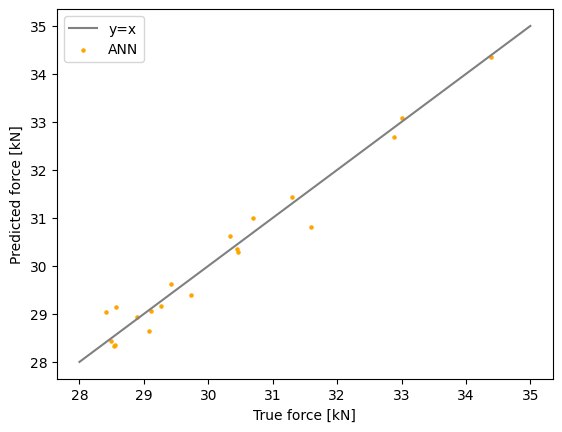

In [ ]:
plt.plot([28,35], [28, 35], label='y=x', color='gray')

plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.legend()